## Create train/test folders

The TensorFlow object-detection API requires that testing and training files should be put in separate folders. The following cells split the data into training and testing folders.

In [1]:
# from pathlib import Path

# DIR_TO_DATA = Path('Dataset files (763.5 MB)/data/4TUDatasetAnonymised')
# ids = [path.stem for path in DIR_TO_DATA.glob(f'*jpg')]

# def test_train_split(l, train_percentage):
#     train = []
#     test = []
#     for elem in l:
#         if random.uniform(0, 1) < train_percentage:
#             train.append(elem)
#         else:
#             test.append(elem)
#     return train, test

  train_ids, test_ids = test_train_split(ids, train_percentage=0.7)

In [2]:
import shutil, os

if not os.path.exists('train'):
    os.makedirs('train')
    if not os.path.exists('test'):
#     os.makedirs('test')

# for image_id in train_ids:
#     path_to_img = os.path.join(str(DIR_TO_DATA), f'{image_id}.jpg')
#     path_to_xml = os.path.join(str(DIR_TO_DATA), f'{image_id}.xml')
#     shutil.copy(path_to_img, 'train/')
#     shutil.copy(path_to_xml, 'train/')

# for image_id in test_ids:
#     path_to_img = os.path.join(str(DIR_TO_DATA), f'{image_id}.jpg')
#     path_to_xml = os.path.join(str(DIR_TO_DATA), f'{image_id}.xml')
#     shutil.copy(path_to_img, 'test/')
#     shutil.copy(path_to_xml, 'test/')

In [59]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import os
import keras
import pathlib
import warnings
import pandas as pd

In [60]:
from pathlib import Path
data_dir = 'Dataset files (763.5 MB)/data/4TUDatasetAnonymised'
DATA_DIR = pathlib.Path(data_dir)
xmls = [path for path in DATA_DIR.glob(f'*xml')]
len(xmls)

284

In [61]:
from keras_retinanet import models
from keras_retinanet.models import load_model

model_path = os.path.join('.','resnet50_coco_best_v2.1.0.h5')
model = models.load_model(model_path, backbone_name='resnet50')

labels_to_names = {0: 'person', 1: 'bicycle', 2: 'car', 3: 'motorcycle', 4: 'airplane', 5: 'bus', 6: 'train', 7: 'truck', 8: 'boat', 9: 'traffic light', 10: 'fire hydrant', 11: 'stop sign', 12: 'parking meter', 13: 'bench', 14: 'bird', 15: 'cat', 16: 'dog', 17: 'horse', 18: 'sheep', 19: 'cow', 20: 'elephant', 21: 'bear', 22: 'zebra', 23: 'giraffe', 24: 'backpack', 25: 'umbrella', 26: 'handbag', 27: 'tie', 28: 'suitcase', 29: 'frisbee', 30: 'skis', 31: 'snowboard', 32: 'sports ball', 33: 'kite', 34: 'baseball bat', 35: 'baseball glove', 36: 'skateboard', 37: 'surfboard', 38: 'tennis racket', 39: 'bottle', 40: 'wine glass', 41: 'cup', 42: 'fork', 43: 'knife', 44: 'spoon', 45: 'bowl', 46: 'banana', 47: 'apple', 48: 'sandwich', 49: 'orange', 50: 'broccoli', 51: 'carrot', 52: 'hot dog', 53: 'pizza', 54: 'donut', 55: 'cake', 56: 'chair', 57: 'couch', 58: 'potted plant', 59: 'bed', 60: 'dining table', 61: 'toilet', 62: 'tv', 63: 'laptop', 64: 'mouse', 65: 'remote', 66: 'keyboard', 67: 'cell phone', 68: 'microwave', 69: 'oven', 70: 'toaster', 71: 'sink', 72: 'refrigerator', 73: 'book', 74: 'clock', 75: 'vase', 76: 'scissors', 77: 'teddy bear', 78: 'hair drier', 79: 'toothbrush'}

tracking <tf.Variable 'Variable_10:0' shape=(9, 4) dtype=float32> anchors
tracking <tf.Variable 'Variable_11:0' shape=(9, 4) dtype=float32> anchors
tracking <tf.Variable 'Variable_12:0' shape=(9, 4) dtype=float32> anchors
tracking <tf.Variable 'Variable_13:0' shape=(9, 4) dtype=float32> anchors
tracking <tf.Variable 'Variable_14:0' shape=(9, 4) dtype=float32> anchors


In [21]:
#!git clone https://github.com/fizyr/keras-retinanet.git

Cloning into 'keras-retinanet'...
remote: Enumerating objects: 11, done.
remote: Counting objects: 100% (11/11), done.
remote: Compressing objects: 100% (9/9), done.
remote: Total 5340 (delta 2), reused 3 (delta 2), pack-reused 5329
Receiving objects: 100% (5340/5340), 13.31 MiB | 811.00 KiB/s, done.
Resolving deltas: 100% (3561/3561), done.


processing time is:  4.31739616394043


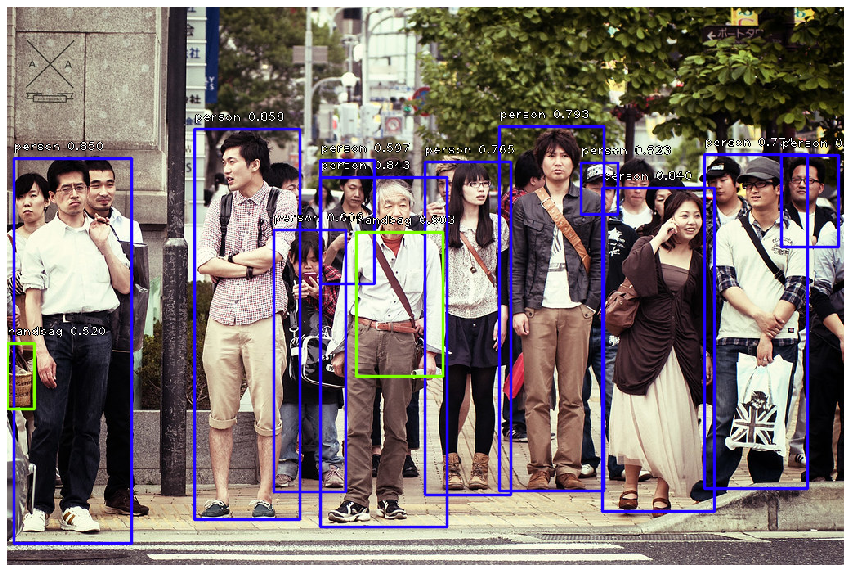

In [62]:
from keras_retinanet.utils.image import (read_image_bgr, preprocess_image, resize_image)
from keras_retinanet.utils.visualization import (draw_box, draw_caption)
from keras_retinanet.utils.colors import label_color
import time
#load image
image = read_image_bgr('people.jpg')

#copy to draw on
draw = image.copy()
draw[:,:,0], draw[:,:,2] = image[:,:,2], image[:,:,0]

#preprocess image for network
image = preprocess_image(image)
image, scale = resize_image(image)

#process image
start = time.time()
boxes, scores, labels = model.predict_on_batch(np.expand_dims(image, axis=0))
print("processing time is: ", time.time() - start)

#image scaling
boxes /= scale

#visualize detections
for box, score, label in zip(boxes[0], scores[0], labels[0]):
    
    if score > 0.5:
      color = label_color(label)
    
      b = box.astype(int)
      draw_box(draw, b, color=color)
    
      caption = "{} {:.3f}".format(labels_to_names[label], score)
      draw_caption(draw, b, caption)

plt.figure(figsize=(15, 15))
plt.axis('off')
plt.imshow(draw)
plt.show()

Dataset files (763.5 MB)/     people.jpg
Dataset files (763.5 MB).zip  resnet50_coco_best_v2.1.0.h5
hw3.ipynb                     test/
keras-retinanet/              train/
keras_retinanet/


In [78]:
def xml_to_csv(path):
    xml_list = []
    for xml_file in glob.glob(path + '/*.xml'):
        xml_path = Path(xml_file)
        tree = ET.parse(xml_file)
        root = tree.getroot()
        for member in root.findall('object'):
            value = (f'{xml_path.stem}.jpg',
                     int(member[4][0].text),
                     int(member[4][1].text),
                     int(member[4][2].text),
                     int(member[4][3].text),
                     member[0].text
                    )
            xml_list.append(value)
    column_name = ['filename', 'xmin', 'ymin', 'xmax', 'ymax', 'class']
    xml_df = pd.DataFrame(xml_list, columns=column_name)
    return xml_df

In [85]:
csv_file = xml_to_csv(data_dir)
csv_file

,filename,xmin,ymin,xmax,ymax,class
0,1192.jpg,37,750,74,799,WF
1,1192.jpg,655,648,719,694,WF
2,1192.jpg,642,807,695,865,WF
3,1192.jpg,887,614,936,670,WF
4,1192.jpg,875,707,935,762,WF
...,...,...,...,...,...,...
7415,1174.jpg,4502,2781,4538,2823,WF
7416,1174.jpg,4115,2459,4155,2495,WF
7417,1148.jpg,774,1054,933,1198,MR
7418,1148.jpg,1317,1914,1397,1984,WF


In [86]:
def create_generators(args, preprocess_image):
    common_args = {
        'batch_size'       : args.batch_size,
        'config'           : args.config,
        'image_min_side'   : args.image_min_side,
        'image_max_side'   : args.image_max_side,
        'no_resize'        : args.no_resize,
        'preprocess_image' : preprocess_image,
    }
    # create random transform generator for augmenting training data
    if args.random_transform:
        transform_generator = random_transform_generator(
            min_rotation=-0.1,
            max_rotation=0.1,
            min_translation=(-0.1, -0.1),
            max_translation=(0.1, 0.1),
            min_shear=-0.1,
            max_shear=0.1,
            min_scaling=(0.9, 0.9),
            max_scaling=(1.1, 1.1),
            flip_x_chance=0.5,
            flip_y_chance=0.5,
        )
        visual_effect_generator = random_visual_effect_generator(
            contrast_range=(0.9, 1.1),
            brightness_range=(-.1, .1),
            hue_range=(-0.05, 0.05),
            saturation_range=(0.95, 1.05)
        )
    else:
        transform_generator = random_transform_generator(flip_x_chance=0.5)
        visual_effect_generator = None